In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
model.train(max_epochs=10, batch_size=16)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it, loss=1.05e+04, v_num=1]


In [5]:
model.module.set_gates_finetune(False)
model.module.set_train_params(expr_train=False, acc_train=True)
model.train(max_epochs=350, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=350 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 350/350: 100%|██████████| 350/350 [26:40<00:00,  4.57s/it, loss=2.31e+04, v_num=1]


In [6]:
## finetune without L0
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=False, acc_train=True)
model.train(max_epochs=100, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49/100:  48%|████▊     | 48/100 [08:35<09:12, 10.62s/it, loss=3.5e+04, v_num=1] 

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


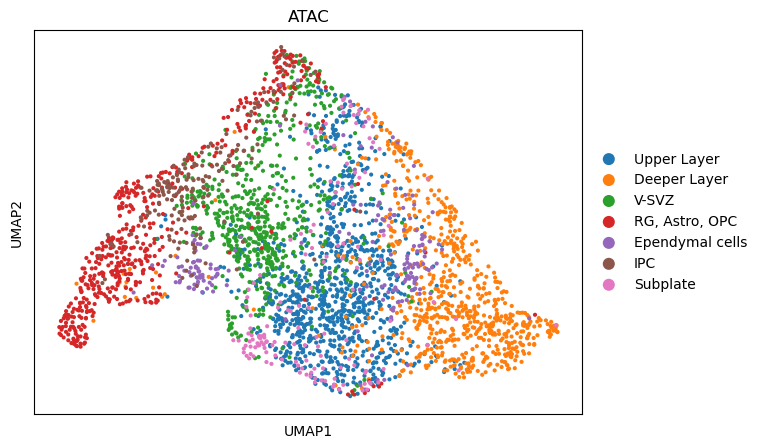

In [16]:
import matplotlib.pyplot as plt


latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'ATAC')
plt.show()

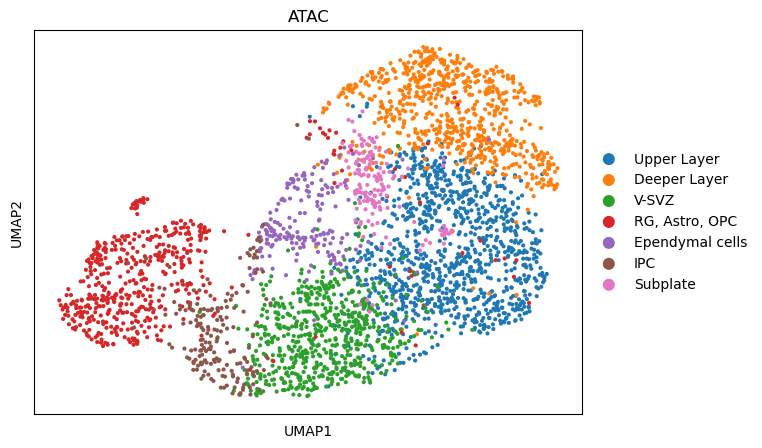

In [28]:
# latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'ATAC')
plt.show()

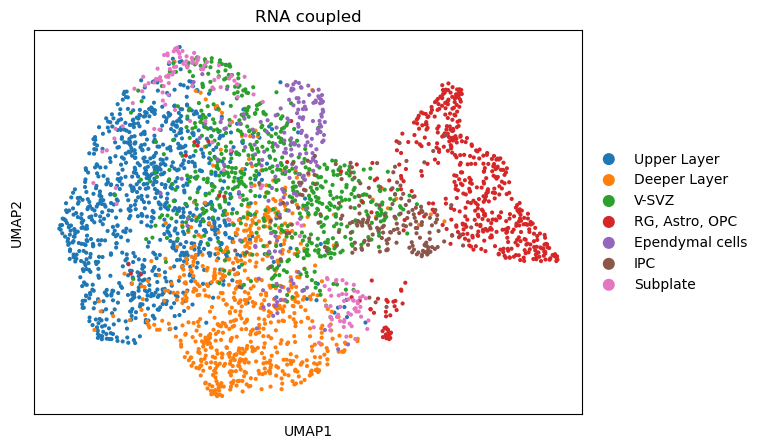

In [29]:
adata_mvi.obsm["latent"] = latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'RNA coupled')
plt.show()

In [31]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()


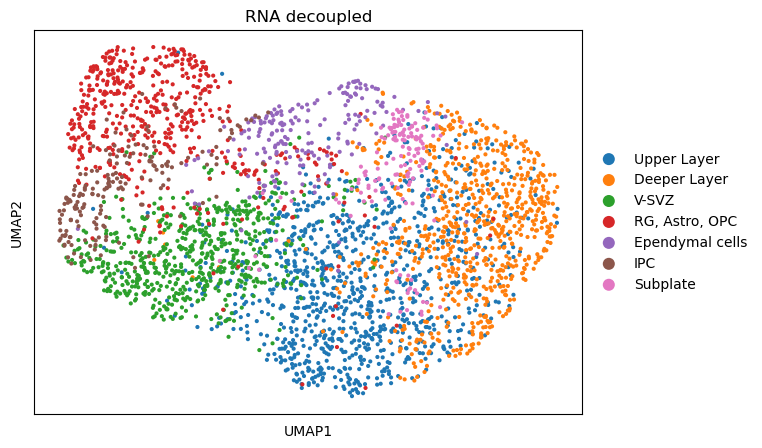

In [32]:
adata_mvi.obsm["latent"] = latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'RNA decoupled')
plt.show()

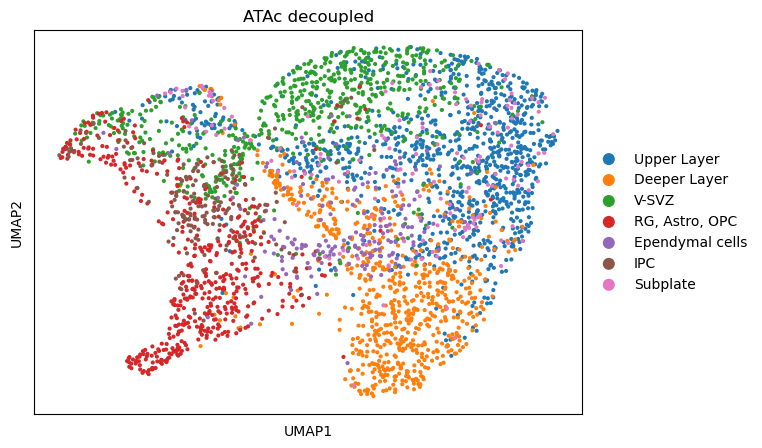

In [33]:
adata_mvi.obsm["latent"] = latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'ATAc decoupled')
plt.show()

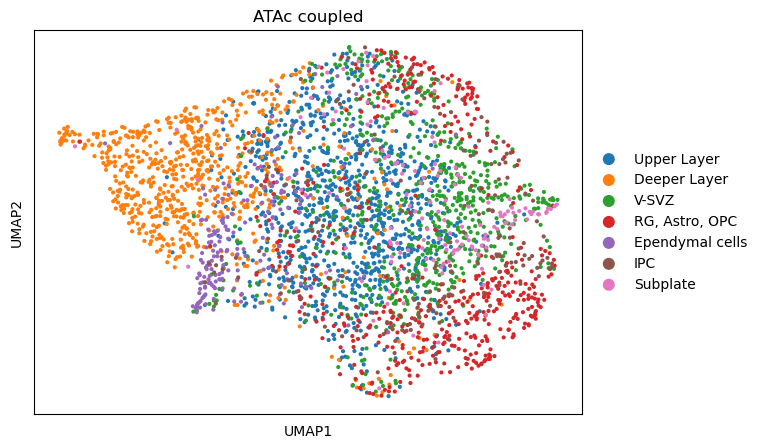

In [21]:
adata_mvi.obsm["latent"] = latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'ATAc coupled')
plt.show()

In [34]:
loadmatrix = model.get_atac_loading()
# loadmatrix_dep = np.abs(np.sum(np.abs(loadmatrix[:, :100])/100, axis=1))
# loadmatrix_indep = np.abs(np.sum(np.abs(loadmatrix[:, 100:])/100, axis=1))
# loadatrix = np.concatenate([[np.abs(loadmatrix_dep)], [np.abs(loadmatrix_indep)]], axis=0)
loadmatrix.shape

single loading shape (1, 80, 123883)
1
single loading shape (1, 80, 123883)
2
single loading shape (1, 80, 123883)
3
single loading shape (1, 80, 123883)
4
single loading shape (1, 80, 123883)
5
single loading shape (1, 80, 123883)
6
single loading shape (1, 80, 123883)
7
single loading shape (1, 80, 123883)
8
single loading shape (1, 80, 123883)
9
single loading shape (1, 80, 123883)
10
single loading shape (1, 80, 123883)
11
single loading shape (1, 80, 123883)
12
single loading shape (1, 80, 123883)
13
single loading shape (1, 80, 123883)
14
single loading shape (1, 80, 123883)
15
single loading shape (1, 80, 123883)
16
single loading shape (1, 80, 123883)
17
single loading shape (1, 80, 123883)
18
single loading shape (1, 80, 123883)
19
single loading shape (1, 80, 123883)
20
single loading shape (1, 80, 123883)
21
single loading shape (1, 80, 123883)
22
single loading shape (1, 80, 123883)
23
single loading shape (1, 80, 123883)
24
single loading shape (1, 80, 123883)
25
single lo

(80, 3344841)

[Text(0.5, 14.722222222222216, 'Peaks')]

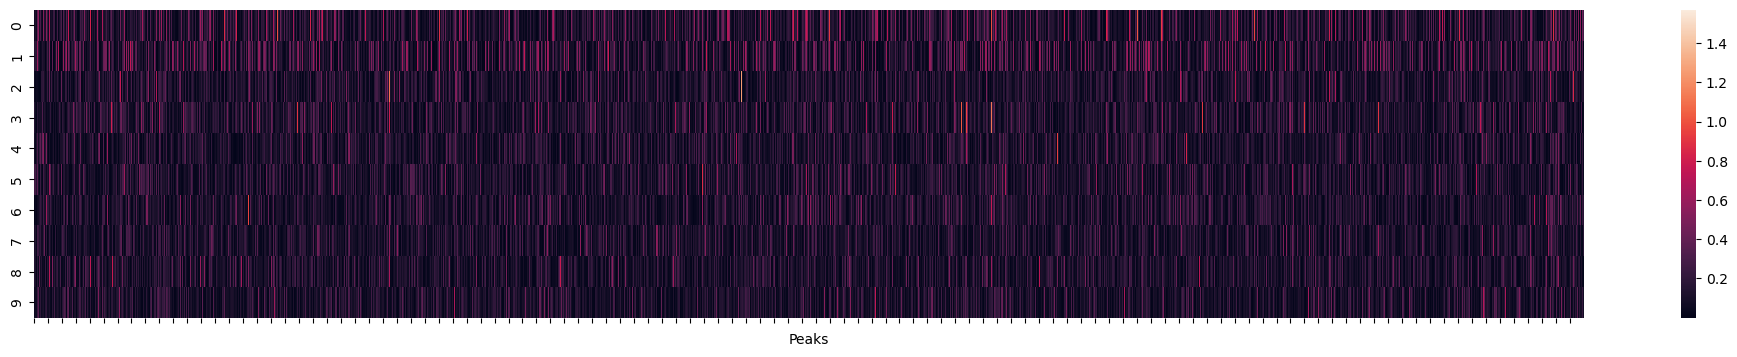

In [47]:
import seaborn as sns
plt.figure(figsize=(25,4))
hm = sns.heatmap(np.abs(loadmatrix[0:80:8, :]))
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

<AxesSubplot:>

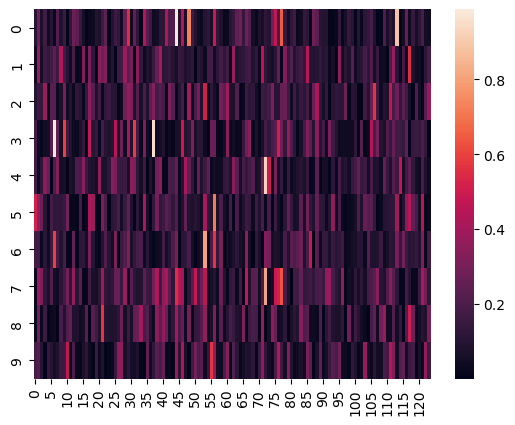

In [20]:
import seaborn as sns

sns.heatmap(np.abs(loadmatrix[0:80:8, 1:123883:1000]))
# plt.show()

In [49]:
def split_loadmatrix(loadmatrix):

    split = np.split(np.abs(loadmatrix), 2, axis=0)
    decouple = np.mean(split[0], axis=0)
    couple = np.mean(split[1], axis=0)
    return decouple, couple

def threshold_matrix(matrix, thresh):
    matrix_new = (matrix > thresh) * matrix
    return matrix_new


decouple, couple = split_loadmatrix(loadmatrix)


<AxesSubplot:ylabel='Count'>

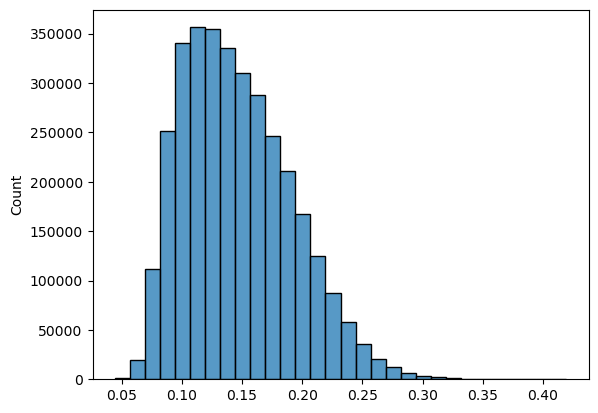

In [34]:
sns.histplot(data=decouple, bins=30)

<AxesSubplot:ylabel='Count'>

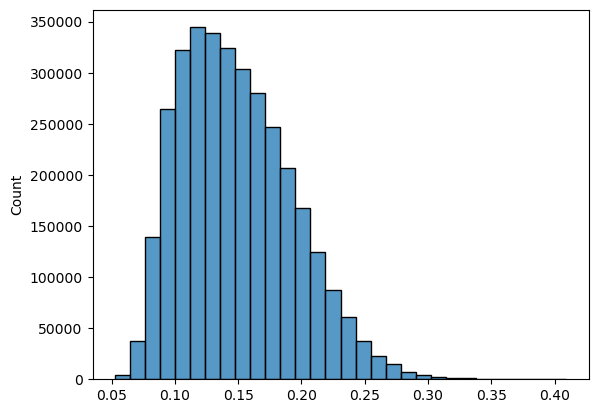

In [35]:
sns.histplot(data=couple, bins=30)

In [53]:
thresh_decouple = threshold_matrix(decouple, 0.2)
thresh_couple = threshold_matrix(couple, 0.2)


[Text(0.5, 23.52222222222222, 'Peaks')]

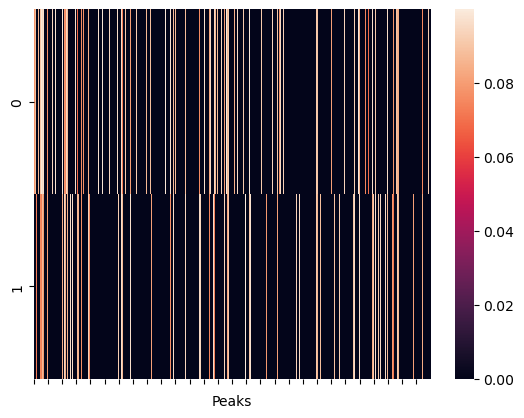

In [38]:
fig, ax = plt.subplots(1)

hm = sns.heatmap(data=[thresh_decouple, thresh_couple])
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

[Text(0.5, 23.52222222222222, 'Peaks')]

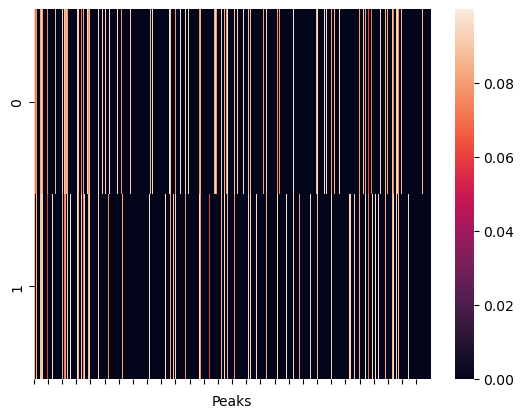

In [40]:
fig, ax = plt.subplots(1)

hm = sns.heatmap(data=[thresh_decouple, thresh_couple])
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label


In [54]:
decouple_index = np.arange(len(decouple))[thresh_decouple > thresh_couple]
print(decouple_index.shape)

couple_index = np.arange(len(couple))[thresh_couple > thresh_decouple]
print(couple_index.shape)

(240113,)
(244785,)


In [50]:
decouple_index

array([     25,      29,      36, ..., 3344810, 3344826, 3344839])

(2, 3344841)


[Text(0.5, -7.277777777777782, 'Peaks')]

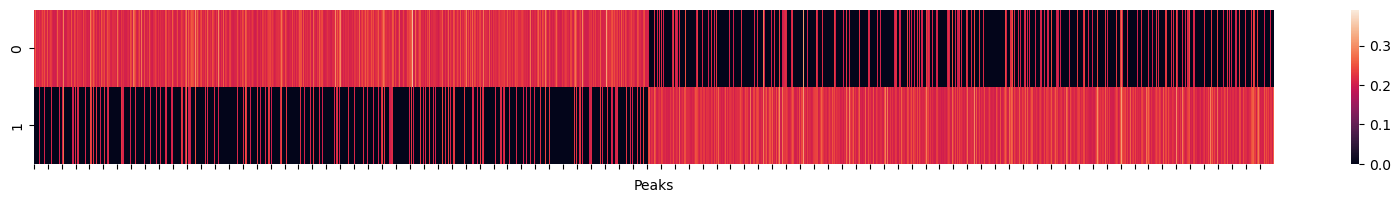

In [55]:
plt.figure(figsize=(20,2))

thresh_index = np.concatenate((decouple_index, couple_index))
# thresh_index = np.sort(thresh_index)
# print(thresh_index.shape)
data = np.array([thresh_decouple, thresh_couple])
print(data.shape)
data = data[:, thresh_index]
hm = sns.heatmap(data=data)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

(2, 3344841)


[Text(0.5, 23.52222222222222, 'Peaks')]

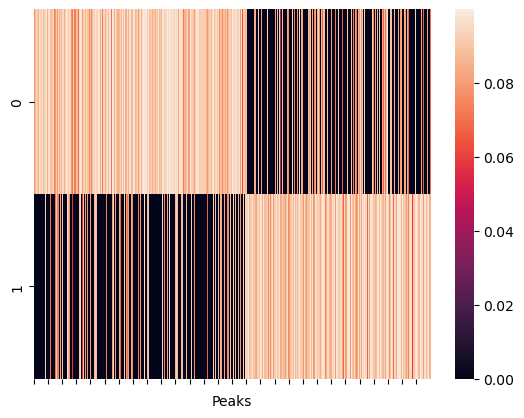

In [41]:
thresh_index = np.concatenate((decouple_index, couple_index))
# thresh_index = np.sort(thresh_index)
# print(thresh_index.shape)
data = np.array([thresh_decouple, thresh_couple])
print(data.shape)
data = data[:, thresh_index]
hm = sns.heatmap(data=data)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks")  # remove the axis label

In [8]:
model.module.set_train_params(expr_train=True, acc_train=False)
model.train(max_epochs=200, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=200 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [19:57<00:00,  5.99s/it, loss=9.58e+03, v_num=1]


In [11]:
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=10, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [01:47<00:00, 10.74s/it, loss=1.17e+05, v_num=1]


In [14]:
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(1)
model.train(max_epochs=10, batch_size=32)


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [01:41<00:00, 10.11s/it, loss=9.4e+04, v_num=1] 


In [15]:
model.module.set_gates_finetune(True)
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=200, batch_size=32)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=200 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [44:26<00:00, 13.33s/it, loss=2.26e+05, v_num=1]


In [24]:
model.save("model_sparse_BM_mouse",overwrite=True)

In [25]:
model = model.load("model_sparse_BM_mouse", adata_mvi)

INFO     File model_sparse_BM_mouse/model.pt already downloaded                              
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


torch.cat(latent_expr).numpy(), torch.cat(latent_atac).numpy(), \
            torch.cat(latent_expr_dep).numpy(), torch.cat(latent_atac_dep).numpy(), \
                torch.cat(latent_expr_indep).numpy(), torch.cat(latent_atac_indep).numpy(), torch.cat(times).numpy()
    

In [26]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [27]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.06000580433759084 and score4 0.06475627974235859


tensor(-0.0048, device='cuda:0', dtype=torch.float64)

In [23]:
latent_atac_dep = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep = torch.tensor(latent_expr_dep).to('cuda')
times = torch.tensor(times).to('cuda')

score1, _, _ = torch_infer_nonsta_dir(latent_atac_dep, latent_expr_dep, times)
score2, _, _ = torch_infer_nonsta_dir(latent_expr_dep, latent_atac_dep, times)
print("score1 {} and score2 {}".format(score1, score2))
score1 - score2

/tmp/ipykernel_3631/565166213.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


score1 0.06456173290428471 and score2 0.06465445089796981


tensor(-9.2718e-05, device='cuda:0', dtype=torch.float64)

In [ ]:

## Test clustering results
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [ ]:
# adata_mvi.obsm["X_scVI"] = latent_expr
# latent_expr.shape

latent_rep = np.concatenate((latent_expr, latent_acc), axis=1)
latent_rep.shape

(3365, 20)

In [ ]:
adata_mvi.obsm["latent_rep"] = latent_acc

In [ ]:
sc.pp.neighbors(adata_mvi, use_rep="latent_rep")
sc.tl.umap(adata_mvi, min_dist=0.3)


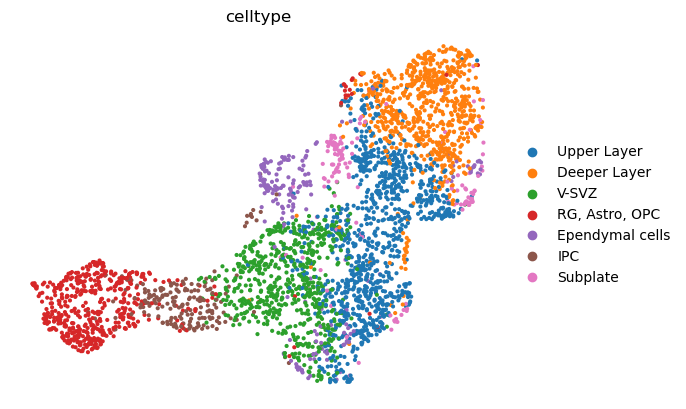

In [ ]:
sc.pl.umap(
    adata_mvi,
    color=["celltype"],
    frameon=False,
)

In [ ]:
sc.tl.leiden(adata_mvi, key_added="leiden_latent", resolution=0.4)


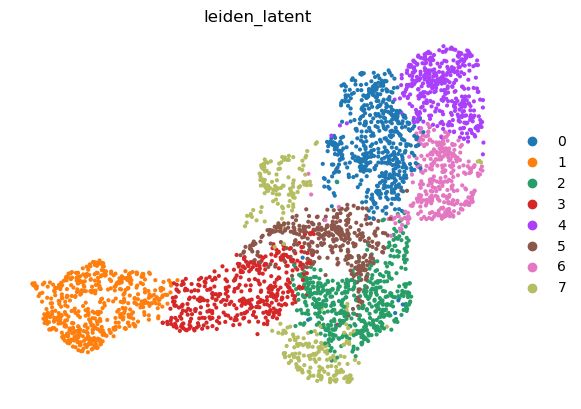

In [ ]:
sc.pl.umap(
    adata_mvi,
    color=["leiden_latent"],
    frameon=False,
)